In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
import numpy as np

In [ ]:
df = pd.read_csv('/content/final_tweets.csv')

In [ ]:
!pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
sentiment_mapping = {1: 2, -1: 0, 0: 1}  # Map old sentiment values to new labels
df['polarity'] = df['sentiment'].map(sentiment_mapping)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

# Tokenize each tweet
df['tokens'] = df['Tweets'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit the vectorizer to your tweets and transform them
tfidf_matrix = vectorizer.fit_transform(df['Tweets'])

# Convert the sparse matrix to a dense array
df['embedded_text'] = tfidf_matrix.toarray().tolist()

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Split data and labels
train_data, test_data, train_labels, test_labels = train_test_split(
    df['embedded_text'].tolist(),  # List of embedded texts
    df['polarity'].tolist(),       # List of polarity labels
    test_size=0.1,                 # 20% for testing, 80% for training
    random_state=42                # For reproducibility
)

In [ ]:
class TweetsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return data, label

In [ ]:
def collate_fn(batch):
    # Separate features (x) and labels (y)
    features = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Pad the features using pad_sequence
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)  # Assumes 0 is the padding token

    # Stack the labels to create a tensor
    labels = torch.tensor(labels)

    return features_padded, labels

train_dataset = TweetsDataset(train_data, train_labels)
test_dataset = TweetsDataset(test_data, test_labels)

# Create DataLoaders using the custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)  # Use the last hidden state output
        out = self.fc(hidden[-1])
        return out

# class LSTMModel(nn.Module):
#             def __init__(self, embedding_dim, hidden_dim, output_dim):
#                 super(LSTMModel, self).__init__()
#                 self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)  # Make it bidirectional
#                 self.fc = nn.Linear(hidden_dim * 2, output_dim)

#             def forward(self, x):
#                 _, (hidden, _) = self.lstm(x)
#                 # Concatenate the forward and backward hidden states
#                 hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
#                 out = self.fc(hidden)
#                 return out

In [ ]:
# Hyperparameters
embedding_dim = 1000
hidden_dim = 128
output_dim = 3  # For three classes: negative, neutral, positive
learning_rate = 0.001



In [ ]:
# Initialize model, loss function, and optimizer
lstm_model = LSTMModel(embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [ ]:
!pip install tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Import tqdm for progress bar



num_epochs = 10  # Set the number of epochs to 50

def train_model(model, optimizer, loader, num_epochs=num_epochs):  # Update function signature
    model.train()

    for epoch in tqdm(range(num_epochs), desc="Training Epochs"): # Add tqdm for progress bar
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for x, y in loader:
            optimizer.zero_grad()

            # Reshape input to (batch_size, sequence_length, input_size)
            # Assuming x has shape (batch_size, embedding_dim * sequence_length)
            # You need to reshape it to (batch_size, sequence_length, embedding_dim)
            sequence_length = x.shape[1] // embedding_dim  # Calculate sequence length
            x = x.view(x.shape[0], sequence_length, embedding_dim)

            output = model(x)  # Pass the reshaped input to the model
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(output, 1)
            total_samples += y.size(0)
            correct_predictions += (predicted == y).sum().item()

        epoch_accuracy = correct_predictions / total_samples
        epoch_loss = total_loss / len(loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy*100:.4f}")

    # You can return the final accuracy and loss if needed
    # return total_loss / len(loader), accuracy


# Call the train_model function to start training
train_model(lstm_model, optimizer, train_loader)



Training Epochs:  10%|█         | 1/10 [00:37<05:37, 37.45s/it]

Epoch [1/10] - Loss: 0.6396, Accuracy: 73.5461


Training Epochs:  20%|██        | 2/10 [01:13<04:50, 36.37s/it]

Epoch [2/10] - Loss: 0.5112, Accuracy: 80.9462


Training Epochs:  30%|███       | 3/10 [01:49<04:15, 36.51s/it]

Epoch [3/10] - Loss: 0.4982, Accuracy: 81.3396


Training Epochs:  40%|████      | 4/10 [02:26<03:39, 36.52s/it]

Epoch [4/10] - Loss: 0.4894, Accuracy: 81.6151


Training Epochs:  50%|█████     | 5/10 [03:02<03:01, 36.35s/it]

Epoch [5/10] - Loss: 0.4806, Accuracy: 81.9196


Training Epochs:  60%|██████    | 6/10 [03:38<02:25, 36.46s/it]

Epoch [6/10] - Loss: 0.4702, Accuracy: 82.1040


Training Epochs:  70%|███████   | 7/10 [04:15<01:49, 36.46s/it]

Epoch [7/10] - Loss: 0.4585, Accuracy: 82.5263


Training Epochs:  80%|████████  | 8/10 [04:50<01:12, 36.15s/it]

Epoch [8/10] - Loss: 0.4450, Accuracy: 83.0130


Training Epochs:  90%|█████████ | 9/10 [05:26<00:36, 36.11s/it]

Epoch [9/10] - Loss: 0.4291, Accuracy: 83.4596


Training Epochs: 100%|██████████| 10/10 [06:03<00:00, 36.36s/it]

Epoch [10/10] - Loss: 0.4093, Accuracy: 84.3619


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, loader):
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # No need to calculate gradients
        for x, y in loader:
            # Reshape input for evaluation - similar to training
            sequence_length = x.shape[1] // embedding_dim  # Calculate sequence length
            x = x.view(x.shape[0], sequence_length, embedding_dim)

            output = model(x)  # Forward pass
            _, predicted = torch.max(output, 1)  # Get class with max probability
            correct += (predicted == y).sum().item()
            total += y.size(0)

            # Store predictions and true labels for precision, recall, and F1 calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    accuracy = correct / total  # Calculate accuracy

    # Calculate additional metrics: Precision, Recall, and F1-Score
    precision = precision_score(all_labels, all_predictions, average='weighted')  # Use 'macro' or 'weighted' for multi-class
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return accuracy, precision, recall, f1

# Evaluate the model and print the results
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(lstm_model, test_loader)

print(f"Test Accuracy: {test_accuracy*100:.4f}%")
print(f"Test Precision: {test_precision*100:.4f}%")
print(f"Test Recall: {test_recall*100:.4f}%")
print(f"Test F1-Score: {test_f1*100:.4f}%")


Test Accuracy: 81.0200%
Test Precision: 81.8946%
Test Recall: 81.0200%
Test F1-Score: 80.7747%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class RNNModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, hidden = self.rnn(x)  # Use the last hidden state output
        out = self.fc(hidden[-1])
        return out


In [ ]:
# Hyperparameters
embedding_dim = 1000  # Should match the Word2Vec embedding size
hidden_dim = 128
output_dim = 3  # For three classes: negative, neutral, positive
learning_rate = 0.001
num_epochs = 15


In [ ]:
# Initialize the RNN model, loss function, and optimizer
rnn_model = RNNModel(embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)


Epoch [1/15], RNN Loss: 0.5004, Training Accuracy: 81.24%
Epoch [2/15], RNN Loss: 0.4976, Training Accuracy: 81.46%
Epoch [3/15], RNN Loss: 0.4966, Training Accuracy: 81.42%
Epoch [4/15], RNN Loss: 0.4954, Training Accuracy: 81.53%
Epoch [5/15], RNN Loss: 0.4938, Training Accuracy: 81.55%
Epoch [6/15], RNN Loss: 0.4930, Training Accuracy: 81.59%
Epoch [7/15], RNN Loss: 0.4920, Training Accuracy: 81.69%
Epoch [8/15], RNN Loss: 0.4916, Training Accuracy: 81.66%
Epoch [9/15], RNN Loss: 0.4908, Training Accuracy: 81.82%
Epoch [10/15], RNN Loss: 0.4903, Training Accuracy: 81.79%
Epoch [11/15], RNN Loss: 0.4895, Training Accuracy: 81.83%
Epoch [12/15], RNN Loss: 0.4888, Training Accuracy: 81.81%
Epoch [13/15], RNN Loss: 0.4880, Training Accuracy: 81.83%
Epoch [14/15], RNN Loss: 0.4881, Training Accuracy: 81.90%
Epoch [15/15], RNN Loss: 0.4870, Training Accuracy: 81.90%


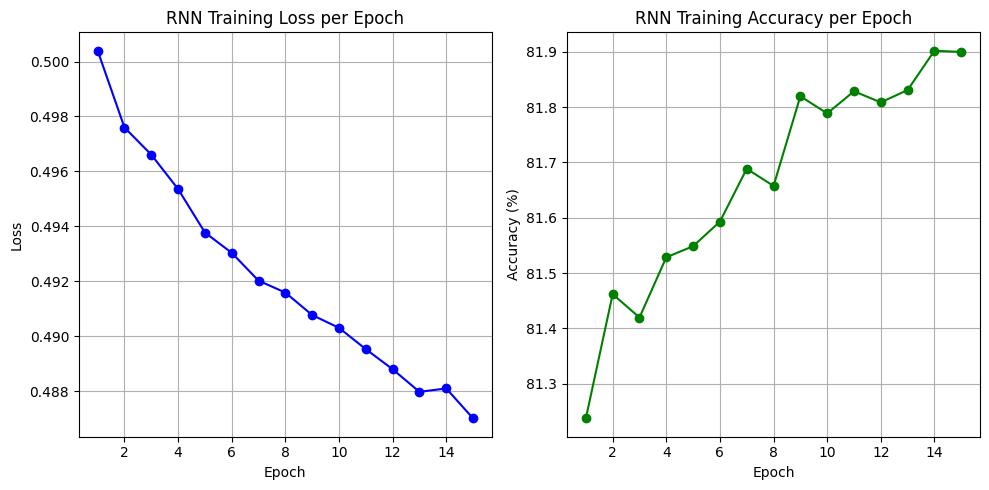

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, optimizer, loader, criterion, embedding_dim):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for x, y in loader:
        # Reshape input for training
        sequence_length = x.shape[1] // embedding_dim  # Calculate sequence length
        x = x.view(x.shape[0], sequence_length, embedding_dim)  # Reshape

        optimizer.zero_grad()  # Clear gradients
        output = model(x)  # Forward pass
        loss = criterion(output, y)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted = output.max(1)  # Get predicted classes
        correct_predictions += (predicted == y).sum().item()  # Count correct predictions
        total_samples += y.size(0)  # Update total samples

    average_loss = total_loss / len(loader)
    accuracy = 100 * correct_predictions / total_samples  # Calculate accuracy as a percentage

    return average_loss, accuracy

# Training the RNN model
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    # Train and record the loss and accuracy
    rnn_loss, train_accuracy = train_model(rnn_model, optimizer, train_loader, criterion, embedding_dim)
    train_losses.append(rnn_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], RNN Loss: {rnn_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

# Plotting the training loss and accuracy
plt.figure(figsize=(10, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b')
plt.title('RNN Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='g')
plt.title('RNN Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model_with_metrics(model, loader, embedding_dim):
    model.eval()  # Set the model to evaluation mode
    all_targets = []
    all_predictions = []

    with torch.no_grad():  # No need to calculate gradients
        for x, y in loader:
            # Reshape input for evaluation (similar to training)
            sequence_length = x.shape[1] // embedding_dim  # Calculate sequence length
            x = x.view(x.shape[0], sequence_length, embedding_dim)  # Reshape

            output = model(x)  # Forward pass
            _, predicted = torch.max(output, 1)  # Get class with max probability

            # Store predictions and targets
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Calculate Accuracy
    accuracy = (np.array(all_predictions) == np.array(all_targets)).sum() / len(all_targets)

    # Calculate Precision, Recall, F1-Score
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    return accuracy, precision, recall, f1

# Evaluate the RNN Model
final_accuracy, precision, recall, f1 = evaluate_model_with_metrics(rnn_model, test_loader, embedding_dim)

# Print Metrics
print(f'Final Test Accuracy: {final_accuracy*100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Final Test Accuracy: 81.06%
Precision: 0.8240
Recall: 0.8106
F1-Score: 0.8098


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out  # No softmax, we’ll use raw scores


class RNNModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, hidden = self.rnn(x)
        out = self.fc(hidden[-1])
        return out  # No softmax, we’ll use raw scores


In [ ]:
import torch

def ensemble_predict_weighted_voting(lstm_model, rnn_model, loader, embedding_dim, lstm_weight=0.6, rnn_weight=0.4):
    """
    Ensemble prediction using weighted voting.
    lstm_weight and rnn_weight should sum up to 1.0.
    """
    lstm_model.eval()
    rnn_model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            # Reshape input for the LSTM and RNN models
            sequence_length = x.shape[1] // embedding_dim
            x_reshaped = x.view(x.shape[0], sequence_length, embedding_dim)

            # Get raw scores from each model (logits before softmax)
            lstm_output = lstm_model(x_reshaped)
            rnn_output = rnn_model(x_reshaped)

            # Get the probability of each class by applying softmax
            lstm_probs = torch.softmax(lstm_output, dim=1)
            rnn_probs = torch.softmax(rnn_output, dim=1)

            # Weighted average of the class probabilities
            ensemble_probs = lstm_probs * lstm_weight + rnn_probs * rnn_weight

            # Final prediction based on the maximum probability
            _, final_pred = torch.max(ensemble_probs, 1)

            # Count correct predictions
            correct += (final_pred == y).sum().item()
            total += y.size(0)

    # Return ensemble accuracy
    return correct / total

# Example usage:
# lstm_weight and rnn_weight are adjustable depending on the individual accuracies of the models
ensemble_accuracy = ensemble_predict_weighted_voting(lstm_model, rnn_model, test_loader, embedding_dim, lstm_weight=0.6, rnn_weight=0.4)
print(f'Ensemble Model Accuracy: {ensemble_accuracy*100:.2f}%')


Ensemble Model Accuracy: 81.20%
